In [2]:
import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol


Using TensorFlow backend.


In [105]:

#Load APA plasmid data (random mpra)
file_path = '../../../../aparent/data/apa_plasmid_data/apa_plasmid_data'

plasmid_dict = isoio.load(file_path)

plasmid_df = plasmid_dict['plasmid_df']
plasmid_cuts = plasmid_dict['plasmid_cuts']

print("len(plasmid_df) = " + str(len(plasmid_df)))


len(plasmid_df) = 3818077


In [106]:

prox_c = np.ravel(plasmid_cuts[:, 180+70+6:180+70+6+35].sum(axis=-1))
total_c = np.ravel(plasmid_cuts[:, 180:180+205].sum(axis=-1)) + np.ravel(plasmid_cuts[:, -1].todense())

plasmid_df['proximal_count_from_cuts'] = prox_c
plasmid_df['total_count_from_cuts'] = total_c


In [109]:
#Filter data (positive set)
kept_libraries = [20]

min_count = 10
min_usage = 0.80

plasmid_df_pos = plasmid_df.copy()

keep_index = np.nonzero(plasmid_df_pos.sublibrary.isin(["doubledope_5prime_0"]))[0]
plasmid_df_pos = plasmid_df_pos.iloc[keep_index].copy()

if kept_libraries is not None :
    keep_index = np.nonzero(plasmid_df_pos.library_index.isin(kept_libraries))[0]
    plasmid_df_pos = plasmid_df_pos.iloc[keep_index].copy()

keep_index = np.nonzero(plasmid_df_pos.seq.str.slice(70, 76).isin(['ATTAAA', 'AATAAA']))[0]
plasmid_df_pos = plasmid_df_pos.iloc[keep_index].copy()

keep_index = np.nonzero(~plasmid_df_pos.seq.str.slice(155, 161).isin(['ATTAAA', 'AATAAA', 'AGTAAA', 'ACTAAA']))[0]
plasmid_df_pos = plasmid_df_pos.iloc[keep_index].copy()

if min_count is not None :
    keep_index = np.nonzero(plasmid_df_pos.total_count_from_cuts >= min_count)[0]
    plasmid_df_pos = plasmid_df_pos.iloc[keep_index].copy()

if min_usage is not None :
    keep_index = np.nonzero(plasmid_df_pos.proximal_count_from_cuts / plasmid_df_pos.total_count_from_cuts >= min_usage)[0]
    plasmid_df_pos = plasmid_df_pos.iloc[keep_index].copy()

print("len(plasmid_df_pos) = " + str(len(plasmid_df_pos)) + " (filtered)")

len(plasmid_df_pos) = 11033 (filtered)


In [114]:
#Filter data (negative set)
kept_libraries = [20]

min_count = 4
max_usage = 0.20

plasmid_df_neg = plasmid_df.copy()

keep_index = np.nonzero(plasmid_df_neg.sublibrary.isin(["doubledope_5prime_0"]))[0]
plasmid_df_neg = plasmid_df_neg.iloc[keep_index].copy()

if kept_libraries is not None :
    keep_index = np.nonzero(plasmid_df_neg.library_index.isin(kept_libraries))[0]
    plasmid_df_neg = plasmid_df_neg.iloc[keep_index].copy()

keep_index = np.nonzero(plasmid_df_neg.seq.str.slice(70, 76).isin(['ATTAAA', 'AATAAA']))[0]
plasmid_df_neg = plasmid_df_neg.iloc[keep_index].copy()

keep_index = np.nonzero(~plasmid_df_neg.seq.str.slice(155, 161).isin(['ATTAAA', 'AATAAA', 'AGTAAA', 'ACTAAA']))[0]
plasmid_df_neg = plasmid_df_neg.iloc[keep_index].copy()

if min_count is not None :
    keep_index = np.nonzero(plasmid_df_neg.total_count_from_cuts >= min_count)[0]
    plasmid_df_neg = plasmid_df_neg.iloc[keep_index].copy()

if max_usage is not None :
    keep_index = np.nonzero(plasmid_df_neg.proximal_count_from_cuts / plasmid_df_neg.total_count_from_cuts <= max_usage)[0]
    plasmid_df_neg = plasmid_df_neg.iloc[keep_index].copy()

print("len(plasmid_df_neg) = " + str(len(plasmid_df_neg)) + " (filtered)")

len(plasmid_df_neg) = 23715 (filtered)


In [115]:

data_df = pd.concat([plasmid_df_pos, plasmid_df_neg]).copy().reset_index(drop=True)

shuffle_index = np.arange(len(data_df))
np.random.shuffle(shuffle_index)

data_df = data_df.iloc[shuffle_index].copy().reset_index(drop=True)

data_df['proximal_usage'] = data_df.proximal_count_from_cuts / data_df.total_count_from_cuts


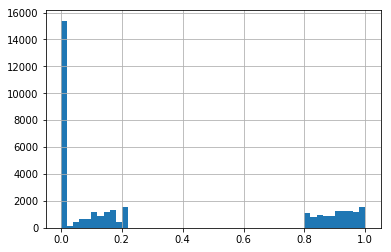

In [116]:
data_df['proximal_usage'].hist(bins=50)

In [ ]:
#Store cached filtered dataframe

pickle.dump({'data_df' : data_df}, open('apa_doubledope_cached_set.pickle', 'wb'))

data_df[['padded_seq', 'proximal_usage']].to_csv('apa_doubledope_cached_set.csv', sep='\t', index=False)
